In [1]:
import pandas as pd
import geopandas as gp 
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline
plt.style.use('default')
from tqdm import tqdm
import glob
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress
import pickle as pkl

from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn import preprocessing

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
files = glob.glob('../BL_Work/openPrescribe/savings/*.gz')

In [4]:
ome = pd.read_csv('scratchpad/ome_rossano.csv')

In [13]:
ome['BNF_stub'] = ome['bnf'].apply(lambda x: x[:-6])

In [14]:
ome.head()

,bnf_name,bnf,mg_per_unit,ome_multiplier,BNF_stub
0,Abstral_Tab Sublingual 100mcg,0407020A0BJAAAW,0.1,130.0,0407020A0
1,Abstral_Tab Sublingual 200mcg,0407020A0BJABAX,0.2,130.0,0407020A0
2,Abstral_Tab Sublingual 300mcg,0407020A0BJACAY,0.3,130.0,0407020A0
3,Abstral_Tab Sublingual 400mcg,0407020A0BJADAZ,0.4,130.0,0407020A0
4,Abstral_Tab Sublingual 600mcg,0407020A0BJAEBA,0.6,130.0,0407020A0


In [16]:
len(set(ome['BNF_stub']))

25

In [461]:
with open('scratchpad/Bipartite_Drug_graph.pkl','rb') as f:
    drug_association_graph  = pkl.load(f)

with open('scratchpad/Bipartite_Drug_category_graph.pkl','rb') as f:
    drug_cat_association_graph  = pkl.load(f)

In [462]:
files = glob.glob('../BL_Work/openPrescribe/savings_Impact/*.h5')
files.sort()
print files

['../BL_Work/openPrescribe/savings_Impact/201406.h5', '../BL_Work/openPrescribe/savings_Impact/201407.h5', '../BL_Work/openPrescribe/savings_Impact/201408.h5', '../BL_Work/openPrescribe/savings_Impact/201409.h5', '../BL_Work/openPrescribe/savings_Impact/201410.h5', '../BL_Work/openPrescribe/savings_Impact/201411.h5', '../BL_Work/openPrescribe/savings_Impact/201412.h5', '../BL_Work/openPrescribe/savings_Impact/201501.h5', '../BL_Work/openPrescribe/savings_Impact/201502.h5', '../BL_Work/openPrescribe/savings_Impact/201503.h5', '../BL_Work/openPrescribe/savings_Impact/201504.h5', '../BL_Work/openPrescribe/savings_Impact/201505.h5', '../BL_Work/openPrescribe/savings_Impact/201506.h5', '../BL_Work/openPrescribe/savings_Impact/201507.h5', '../BL_Work/openPrescribe/savings_Impact/201508.h5', '../BL_Work/openPrescribe/savings_Impact/201509.h5', '../BL_Work/openPrescribe/savings_Impact/201510.h5', '../BL_Work/openPrescribe/savings_Impact/201511.h5', '../BL_Work/openPrescribe/savings_Impact/2015

In [463]:
files[19]

'../BL_Work/openPrescribe/savings_Impact/201601.h5'

In [464]:
pdp = pd.read_hdf(files[0])
pdp.dropna()
for file in files[0:0+3]:
    pdp2 = pd.read_hdf(file)
    pdp2.dropna()
    pdp.append(pdp2)

In [465]:
pdp.head()

Unnamed: 0    0    1       2                3  \
0 34712       43870  Q44  01R  N81016  0101010C0BBAAAA   
  47626       56784  Q44  01R  N81068  0101010C0BBAAAA   
  50737       59895  Q44  01R  N81084  0101010C0BBAAAA   
  55199       64357  Q44  01R  N81614  0101010C0AAAAAA   
  74259       83978  Q44  02D  N81127  0101010C0BBAAAA   

                                                4    5      6      7      8  \
0 34712  Alu-Cap_Cap 475mg                         1.0  27.42  25.34  240.0   
  47626  Alu-Cap_Cap 475mg                         1.0  41.13  38.00  360.0   
  50737  Alu-Cap_Cap 475mg                         1.0  54.84  50.66  480.0   
  55199  Alum Hydrox_Cap 475mg                     1.0  13.71  12.66  120.0   
  74259  Alu-Cap_Cap 475mg                         1.0  38.39  35.57  336.0   

                9       10         11   12           13                   14  \
0 34712  201406.0  CW1 3AW  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  47626  201406.0  CW1 3HB  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  50737  201406.0  CW2 5DA  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  55199  201406.0  CW5 8EW  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  74259  201406.0  CW7 1AT  0101010C0  NaN  indigestion  Aluminium Hydroxide   

            15         16    17   18    19  20     21        22   23        24  
0 34712  475.0  0101010C0  20.0  1.0  20.0  BB  0.115  0.110952  0.0  1.979167  
  47626  475.0  0101010C0  30.0  1.0  30.0  BB  0.115  0.110952  0.0  1.319444  
  50737  475.0  0101010C0  40.0  1.0  40.0  BB  0.115  0.110952  0.0  0.989583  
  55199  475.0  0101010C0  10.0  1.0  10.0  AA  0.115  0.110952  0.0  3.958333  
  74259  475.0  0101010C0  28.0  1.0  28.0  BB  0.115  0.110952  0.0  1.413690

In [466]:
len(pdp)

8932165

In [467]:
bnf_ome_map_df = {'BNF' : [] , 'OME':[] , 'BNF_variants' : []}
for name , group in ome.groupby('BNF_stub'):
    bnf_ome_map_df['BNF'].append(name)
    bnf_ome_map_df['BNF_variants'].append(set(group['bnf_name']))
    bnf_ome_map_df['OME'].append(list(set(group['ome_multiplier']))[0])
bnf_ome_map_df = pd.DataFrame.from_dict(bnf_ome_map_df)

In [469]:
bnf_ome_map = {}
for name , group in ome.groupby('BNF_stub'):
#     if list(set(group['ome_multiplier']))[0] < 0:
    bnf_ome_map[name] = list(set(group['ome_multiplier']))[0]

In [470]:
bnf_ome_map_df.head()

,BNF,BNF_variants,OME
0,040702020AAAA,{Morph/Cyclizine_Inj 10mg/50mg 1ml Amp},2.0
1,040702020AAAB,{Morph/Cyclizine_Inj 15mg/50mg 1ml Amp},2.0
2,040702020BBAA,{Cyclimorph 10_Inj 1ml Amp},2.0
3,040702020BBAB,{Cyclimorph 15_Inj 1ml Amp},2.0
4,040702040AAAA,{Tramadol HCl_Cap 50mg},0.1


In [471]:
bnf_ome_map = {}
for index, row in bnf_ome_map_df.iterrows():
    bnf_ome_map[row['BNF']] = row['OME']

In [605]:
for k in bnf_ome_map:
    if 'codeine' in k.lower():
        print(k,bnf_ome_map[k])

In [598]:
%store bnf_ome_map_df

Stored 'bnf_ome_map_df' (DataFrame)


In [472]:
 bnf_ome_map_df[bnf_ome_map_df['OME'] < 10]

,BNF,BNF_variants,OME
0,040702020AAAA,{Morph/Cyclizine_Inj 10mg/50mg 1ml Amp},2.00
1,040702020AAAB,{Morph/Cyclizine_Inj 15mg/50mg 1ml Amp},2.00
2,040702020BBAA,{Cyclimorph 10_Inj 1ml Amp},2.00
3,040702020BBAB,{Cyclimorph 15_Inj 1ml Amp},2.00
4,040702040AAAA,{Tramadol HCl_Cap 50mg},0.10
5,040702040AAAB,{Tramadol HCl_Inj 50mg/ml 2ml Amp},0.10
6,040702040AAAC,{Tramadol HCl_Tab 100mg M/R},0.10
7,040702040AAAD,{Tramadol HCl_Tab 150mg M/R},0.10
8,040702040AAAE,{Tramadol HCl_Tab 200mg M/R},0.10
9,040702040AAAF,{Tramadol HCl_Tab Solb 50mg S/F},0.10


In [473]:
pdp['25'] = pdp['3'].apply(lambda x : x[:-2])

In [474]:
pdp.head()

Unnamed: 0    0    1       2                3  \
0 34712       43870  Q44  01R  N81016  0101010C0BBAAAA   
  47626       56784  Q44  01R  N81068  0101010C0BBAAAA   
  50737       59895  Q44  01R  N81084  0101010C0BBAAAA   
  55199       64357  Q44  01R  N81614  0101010C0AAAAAA   
  74259       83978  Q44  02D  N81127  0101010C0BBAAAA   

                                                4    5      6      7      8  \
0 34712  Alu-Cap_Cap 475mg                         1.0  27.42  25.34  240.0   
  47626  Alu-Cap_Cap 475mg                         1.0  41.13  38.00  360.0   
  50737  Alu-Cap_Cap 475mg                         1.0  54.84  50.66  480.0   
  55199  Alum Hydrox_Cap 475mg                     1.0  13.71  12.66  120.0   
  74259  Alu-Cap_Cap 475mg                         1.0  38.39  35.57  336.0   

                9       10         11   12           13                   14  \
0 34712  201406.0  CW1 3AW  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  47626  201406.0  CW1 3HB  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  50737  201406.0  CW2 5DA  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  55199  201406.0  CW5 8EW  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  74259  201406.0  CW7 1AT  0101010C0  NaN  indigestion  Aluminium Hydroxide   

            15         16    17   18    19  20     21        22   23  \
0 34712  475.0  0101010C0  20.0  1.0  20.0  BB  0.115  0.110952  0.0   
  47626  475.0  0101010C0  30.0  1.0  30.0  BB  0.115  0.110952  0.0   
  50737  475.0  0101010C0  40.0  1.0  40.0  BB  0.115  0.110952  0.0   
  55199  475.0  0101010C0  10.0  1.0  10.0  AA  0.115  0.110952  0.0   
  74259  475.0  0101010C0  28.0  1.0  28.0  BB  0.115  0.110952  0.0   

               24             25  
0 34712  1.979167  0101010C0BBAA  
  47626  1.319444  0101010C0BBAA  
  50737  0.989583  0101010C0BBAA  
  55199  3.958333  0101010C0AAAA  
  74259  1.413690  0101010C0BBAA

In [475]:
opioids_ome = pdp[pdp['25'].isin(ome['BNF_stub'])]

In [476]:
opioids_ome = opioids_ome[opioids_ome['15']>0]

In [477]:
opioids_ome.size

6845904

In [499]:
opioids_ome['mcg_potency'] = opioids_ome['15']*1000.0 

In [500]:
opioids_ome.head(n=100)

Unnamed: 0    0    1       2                3  \
494 113277       125692  Q44  02F  N81006  040702020BBABAB   
    167785       183942  Q44  12F  N85008  040702020BBABAB   
    240901       267479  Q45  00D  A83001  040702020BBABAB   
    1347159     1525127  Q48  01V  N84014  040702020AAABAB   
    1352084     1530052  Q48  01V  N84021  040702020BBAAAA   
    1612255     1814698  Q49  00L  A84026  040702020AAAAAA   
    1762893     1989896  Q49  01H  A82037  040702020BBAAAA   
    1779350     2008636  Q49  01H  A82053  040702020AAAAAA   
    1782211     2012877  Q49  01H  A82058  040702020BBAAAA   
    2154693     2459300  Q51  02Q  C84008  040702020AAABAB   
    2194127     2504758  Q51  02X  C86022  040702020BBABAB   
    2226549     2541737  Q51  03L  C87004  040702020AAAAAA   
    2793730     3172317  Q53  05A  M84616  040702020BBAAAA   
    2954808     3355109  Q53  05R  M84021  040702020AAAAAA   
    2964304     3364605  Q53  05R  M84030  040702020BBAAAA   
    2964305     3364606  Q53  05R  M84030  040702020BBABAB   
    3040853     3447166  Q53  06D  M81040  040702020BBABAB   
    3822127     4344841  Q55  04R  C81652  040702020BBABAB   
    3850657     4383385  Q56  06H  D81022  040702020BBABAB   
    3869990     4402718  Q56  06H  D81034  040702020BBAAAA   
    3888693     4424611  Q56  06H  D81050  040702020BBABAB   
    3988995     4537549  Q56  06L  D83053  040702020AAAAAA   
    4003876     4552430  Q56  06L  D83079  040702020BBABAB   
    4008142     4556696  Q56  06L  D83082  040702020BBAAAA   
    4052619     4610915  Q56  06V  D82016  040702020BBABAB   
    4157957     4721490  Q56  07J  D82051  040702020BBABAB   
    4167243     4730776  Q56  07J  D82079  040702020BBAAAA   
    4211174     4774805  Q56  07K  D83076  040702020BBAAAA   
    4238811     4803508  Q57  06Q  F81087  040702020AAABAB   
    4312659     4893196  Q57  06T  F81606  040702020AAAAAA   
...                 ...  ...  ...     ...              ...   
    8323951     9436474  Q69  10M  K81050  040702020BBABAB   
    8345655     9459600  Q69  10N  K81077  040702020BBABAB   
    8372194     9489752  Q69  10Q  K84023  040702020AAAAAA   
    8389560     9507118  Q69  10Q  K84037  040702020BBABAB   
    8527188     9663934  Q69  11D  K81047  040702020BBAAAA   
    8532068     9668814  Q69  11D  K81069  040702020BBAAAA   
    8533848     9670594  Q69  11D  K81070  040702020BBAAAA   
    8592258     9742933  Q70  10L  J84005  040702020BBAAAA   
    8618005     9772790  Q70  10R  J82073  040702020BBAAAA   
    8717282     9896516  Q70  11A  J82034  040702020BBABAB   
    8774683     9953917  Q70  11A  J82156  040702020BBABAB   
    8781852     9964181  Q70  11A  J82214  040702020BBABAB   
    8815260    10002833  Q70  11J  J81027  040702020BBABAB   
495 624            2404  Q44  01C  N81002  040702040AAAAAA   
    625            2405  Q44  01C  N81002  040702040AAACAC   
    626            2406  Q44  01C  N81002  040702040AAAFAF   
    627            2407  Q44  01C  N81002  040702040AAAJAJ   
    628            2408  Q44  01C  N81002  040702040BIAAAC   
    629            2409  Q44  01C  N81002  040702040BNAFAC   
    630            2410  Q44  01C  N81002  040702040BPABAH   
    2224           4004  Q44  01C  N81013  040702040AAAAAA   
    2225           4005  Q44  01C  N81013  040702040AAADAD   
    2226           4006  Q44  01C  N81013  040702040AAAGAG   
    2227           4007  Q44  01C  N81013  040702040AAAHAH   
    2228           4008  Q44  01C  N81013  040702040AAAUAU   
    2229           4009  Q44  01C  N81013  040702040BNADAE   
    2230           4010  Q44  01C  N81013  040702040BNAEAD   
    2231           4011  Q44  01C  N81013  040702040BNAFAC   
    2232           4012  Q44  01C  N81013  040702040BPAAAG   
    3729           6961  Q44  01C  N81022  040702040AAAAAA   

                                                    4     5       6       7  \
494 113277   Cyclimorph 15_Inj 1ml Amp                  1.0    1.82    1.68   
    167785

In [501]:
set(opioids_ome['16'])

{'040702020',
 '040702040',
 '040702050',
 '0407020A0',
 '0407020AD',
 '0407020AF',
 '0407020AG',
 '0407020B0',
 '0407020C0',
 '0407020D0',
 '0407020G0',
 '0407020H0',
 '0407020K0',
 '0407020L0',
 '0407020M0',
 '0407020P0',
 '0407020Q0',
 '0407020T0',
 '0407020V0'}

In [502]:
bnf_ome_map

{'040702020AAAA': 2.0,
 '040702020AAAB': 2.0,
 '040702020BBAA': 2.0,
 '040702020BBAB': 2.0,
 '040702040AAAA': 0.1,
 '040702040AAAB': 0.1,
 '040702040AAAC': 0.1,
 '040702040AAAD': 0.1,
 '040702040AAAE': 0.1,
 '040702040AAAF': 0.1,
 '040702040AAAG': 0.1,
 '040702040AAAH': 0.1,
 '040702040AAAI': 0.1,
 '040702040AAAJ': 0.1,
 '040702040AAAM': 0.1,
 '040702040AAAN': 0.1,
 '040702040AAAP': 0.1,
 '040702040AAAT': 0.1,
 '040702040AAAU': 0.1,
 '040702040AAAV': 0.1,
 '040702040AAAW': 0.1,
 '040702040AAAX': 0.1,
 '040702040AAAY': 0.1,
 '040702040AAAZ': 0.1,
 '040702040AABA': 0.1,
 '040702040AABB': 0.1,
 '040702040AABC': 0.1,
 '040702040AABD': 0.1,
 '040702040BBAA': 0.1,
 '040702040BBAB': 0.1,
 '040702040BBAC': 0.1,
 '040702040BBAD': 0.1,
 '040702040BBAE': 0.1,
 '040702040BBAF': 0.1,
 '040702040BBAG': 0.1,
 '040702040BBAH': 0.1,
 '040702040BBAI': 0.1,
 '040702040BBAJ': 0.1,
 '040702040BBAK': 0.1,
 '040702040BCAA': 0.1,
 '040702040BDAA': 0.1,
 '040702040BDAB': 0.1,
 '040702040BDAC': 0.1,
 '040702040

In [503]:
def func_ome(df,drugBNF,ome_map):
    df['26'] = df['8'] *df['mcg_potency']*ome_map[drugBNF]
    df['27'] =  ome_map[drugBNF]
    df['28'] = df['8'] * df['mcg_potency']
    return df
    

def calculateOME(pdp,ome_map):
    pdp['26'] = 0.0
    return pdp.groupby('25',as_index=False).apply(lambda df: func_ome(df , df.name, ome_map ))

ome_df = calculateOME(opioids_ome , bnf_ome_map)

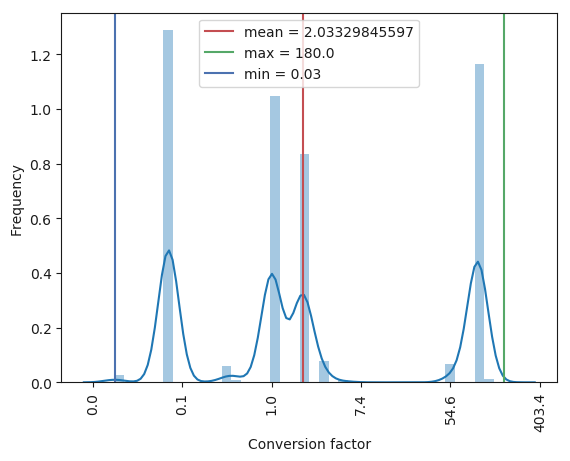

In [504]:
sns.distplot(np.log(ome_df['27']))

mean_val = np.mean(np.log(ome_df['27']))
max_val = np.max(np.log(ome_df['27']))
min_val = np.min(np.log(ome_df['27']))
plt.axvline(x=mean_val,label='mean = {}'.format(np.exp(mean_val)) , c = 'r')
plt.axvline(x=max_val,label='max = {}'.format(np.exp(max_val)), c = 'g')
plt.axvline(x=min_val,label='min = {}'.format(np.exp(min_val)), c = 'b')
ax = plt.gca()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.xticks(rotation=90)

plt.xlabel('Conversion factor')
plt.ylabel('Frequency')

plt.legend()
plt.show()

In [505]:
min(ome_df['27']) , max(ome_df['27']) , np.mean(ome_df['27'])

(0.03, 180.0, 27.252682368857677)

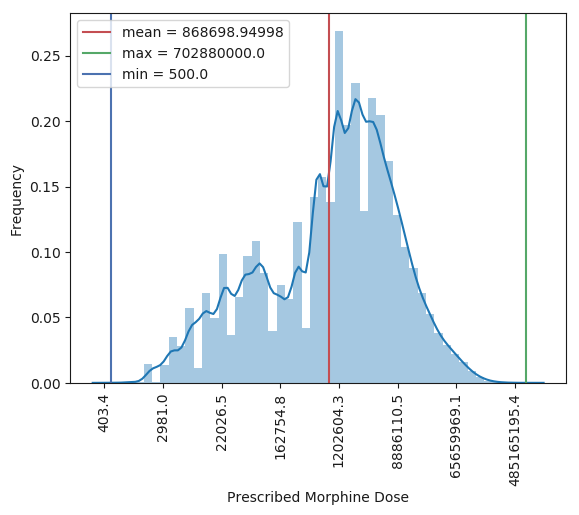

In [506]:
sns.distplot(np.log(ome_df['26']))

mean_val = np.mean(np.log(ome_df['26']))
max_val = np.max(np.log(ome_df['26']))
min_val = np.min(np.log(ome_df['26']))
plt.axvline(x=mean_val,label='mean = {}'.format(np.exp(mean_val)) , c = 'r')
plt.axvline(x=max_val,label='max = {}'.format(np.exp(max_val)), c = 'g')
plt.axvline(x=min_val,label='min = {}'.format(np.exp(min_val)), c = 'b')

ax = plt.gca()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.xticks(rotation=90)

plt.xlabel('Prescribed Morphine Dose')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [485]:
min(ome_df['26']) , max(ome_df['26']) , np.mean(ome_df['26'])

(0.5, 702880.0, 5369.817701496748)

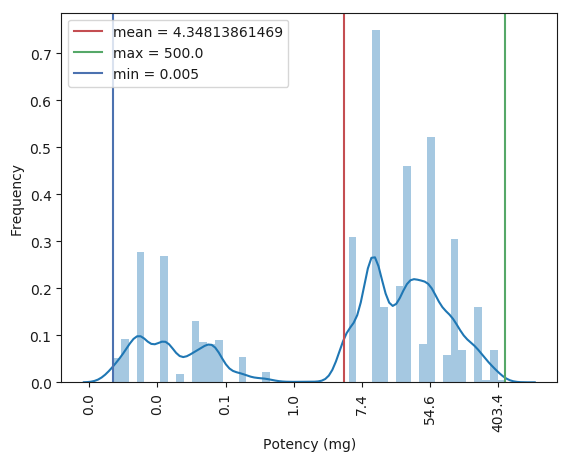

In [486]:
sns.distplot(np.log(ome_df['15']))

mean_val = np.mean(np.log(ome_df['15']))
max_val = np.max(np.log(ome_df['15']))
min_val = np.min(np.log(ome_df['15']))
plt.axvline(x=mean_val,label='mean = {}'.format(np.exp(mean_val)) , c = 'r')
plt.axvline(x=max_val,label='max = {}'.format(np.exp(max_val)), c = 'g')
plt.axvline(x=min_val,label='min = {}'.format(np.exp(min_val)), c = 'b')

ax = plt.gca()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.xticks(rotation=90)

plt.xlabel('Potency (mg)')
plt.ylabel('Frequency')

plt.legend()
plt.show()

In [487]:
min(ome_df['15']) , max(ome_df['15']) , np.mean(ome_df['15'])

(0.005, 500.0, 38.213252295381615)

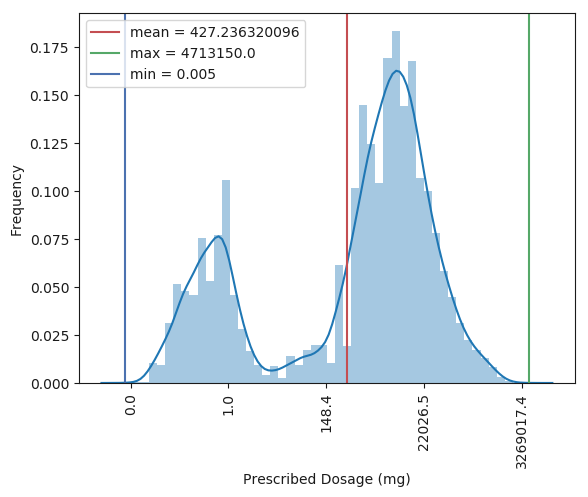

In [491]:
sns.distplot(np.log(ome_df['28']))

mean_val = np.mean(np.log(ome_df['28']))
max_val = np.max(np.log(ome_df['28']))
min_val = np.min(np.log(ome_df['28']))
plt.axvline(x=mean_val,label='mean = {}'.format(np.exp(mean_val)) , c = 'r')
plt.axvline(x=max_val,label='max = {}'.format(np.exp(max_val)), c = 'g')
plt.axvline(x=min_val,label='min = {}'.format(np.exp(min_val)), c = 'b')

ax = plt.gca()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.xticks(rotation=90)

plt.xlabel('Prescribed Dosage (mg)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [214]:
min(ome_df['28']) , max(ome_df['28']) , np.mean(ome_df['28'])

(0.005, 4713150.0, 21803.659078893965)

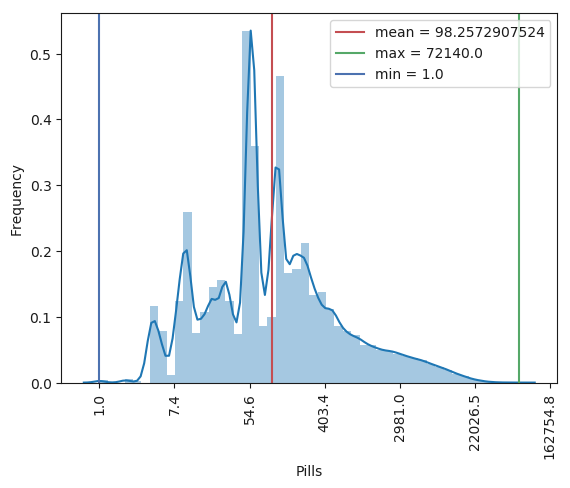

In [507]:
sns.distplot(np.log(ome_df['8']))

mean_val = np.mean(np.log(ome_df['8']))
max_val = np.max(np.log(ome_df['8']))
min_val = np.min(np.log(ome_df['8']))
plt.axvline(x=mean_val,label='mean = {}'.format(np.exp(mean_val)) , c = 'r')
plt.axvline(x=max_val,label='max = {}'.format(np.exp(max_val)), c = 'g')
plt.axvline(x=min_val,label='min = {}'.format(np.exp(min_val)), c = 'b')
ax = plt.gca()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.xticks(rotation=90)

plt.xlabel('Pills')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [508]:
min(ome_df['8']) , max(ome_df['8']) , np.mean(ome_df['8'])

(1.0, 72140.0, 609.1868137502366)

In [509]:
ome_df[ome_df['8'] > 72000]

,,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,mcg_potency,27,28
495,4920693,5573280,Q59,03T,C83019,040702040AAAAAA,Tramadol HCl_Cap 50mg,511.0,2380.46,2215.24,72140.0,201406.0,PE25 2RN,040702040,NaN,pain,Tramadol Hydrochloride,50.0,040702040,72140.0,1.0,72140.0,AA,0.146667,0.087143,0.0,0.000693,040702040AAAA,360700000.0,50000.0,0.1,3.607000e+09


In [519]:
ome_df['ln_potency'] = np.log(ome_df['mcg_potency'])
ome_df['ln_pills'] = np.log(ome_df['8'])
ome_df['ln_dosage'] = np.log(ome_df['28'])
ome_df['potency_rank'] = ome_df['ln_potency'].rank(method='first')
ome_df['pills_rank'] = ome_df['ln_pills'].rank(method='first')
ome_df['dosage_rank'] = ome_df['ln_dosage'].rank(method='first')

In [520]:
ome_df['ln_ome'] = np.log(ome_df['27'])

In [521]:
ome_df['potency_quantile'] = pd.qcut(ome_df['potency_rank'],50 ,labels=np.arange(1,51,1))
ome_df['pills_quantile'] = pd.qcut(ome_df['pills_rank'],50, labels=np.arange(1,51,1))
ome_df['dosage_quantile'] = pd.qcut(ome_df['dosage_rank'],50, labels=np.arange(1,51,1))

In [522]:
ome_df.head()

Unnamed: 0    0    1       2                3  \
494 113277       125692  Q44  02F  N81006  040702020BBABAB   
    167785       183942  Q44  12F  N85008  040702020BBABAB   
    240901       267479  Q45  00D  A83001  040702020BBABAB   
    1347159     1525127  Q48  01V  N84014  040702020AAABAB   
    1352084     1530052  Q48  01V  N84021  040702020BBAAAA   

                                                    4     5       6       7  \
494 113277   Cyclimorph 15_Inj 1ml Amp                  1.0    1.82    1.68   
    167785   Cyclimorph 15_Inj 1ml Amp                  4.0  109.44  101.12   
    240901   Cyclimorph 15_Inj 1ml Amp                  1.0    3.65    3.48   
    1347159  Morph/Cyclizine_Inj 15mg/50mg 1ml Amp     10.0   89.36   83.05   
    1352084  Cyclimorph 10_Inj 1ml Amp                  2.0   87.70   81.02   

                8         9        10         11   12    13  \
494 113277    1.0  201406.0   CW6 9PE  040702020  NaN  pain   
    167785   60.0  201406.0  CH49 5PL  040702020  NaN  pain   
    240901    2.0  201406.0  DL16 6QA  040702020  NaN  pain   
    1347159  49.0  201406.0   PR8 3LB  040702020  NaN  pain   
    1352084  50.0  201406.0   PR9 0TZ  040702020  NaN  pain   

                                                 14    15         16    17  \
494 113277   Morphine Tartrate & Cyclizine Tartrate  15.0  040702020   1.0   
    167785   Morphine Tartrate & Cyclizine Tartrate  15.0  040702020  60.0   
    240901   Morphine Tartrate & Cyclizine Tartrate  15.0  040702020   2.0   
    1347159  Morphine Tartrate & Cyclizine Tartrate  50.0  040702020  49.0   
    1352084  Morphine Tartrate & Cyclizine Tartrate  10.0  040702020  50.0   

              18     19  20    21    22     23         24             25  \
494 113277   1.5    1.5  BB  1.00  1.68   0.68  15.000000  040702020BBAB   
    167785   1.5   90.0  BB  1.00  1.68  40.80   0.250000  040702020BBAB   
    240901   1.5    3.0  BB  1.00  1.68   1.36   7.500000  040702020BBAB   
    1347159  5.0  245.0  AA  1.62  1.00   0.00   1.020408  040702020AAAB   
    1352084  1.0   50.0  BB  1.00  1.62  31.00   0.200000  040702020BBAA   

                    26  mcg_potency   27         28  ln_potency  ln_pills  \
494 113277     30000.0      15000.0  2.0    15000.0    9.615805  0.000000   
    167785   1800000.0      15000.0  2.0   900000.0    9.615805  4.094345   
    240901     60000.0      15000.0  2.0    30000.0    9.615805  0.693147   
    1347159  4900000.0      50000.0  2.0  2450000.0   10.819778  3.891820   
    1352084  1000000.0      10000.0  2.0   500000.0    9.210340  3.912023   

             ln_dosage  potency_rank  pills_rank  dosage_rank    ln_ome  \
494 113277    9.615805      130785.0         1.0      65272.0  0.693147   
    167785   13.710150      130786.0    103193.0      97145.0  0.693147   
    240901   10.308953      130787.0       218.0      67001.0  0.693147   
    1347159  14.711599      183883.0     73770.0     130567.0  0.693147   
    1352084  13.122363       87055.0     73847.0      83099.0  0.693147   

            potency_quantile pills_quantile dosage_quantile  
494 113277                26              1              13  
    167785                26             21              20  
    240901                26              1              14  
    1347159               37             15              26  
    1352084               18             15              17

In [548]:
binned_mean_OME_potency = {}
binned_mean_OME_pills = {}
binned_mean_OME_dosage = {}

binned_mean_potency_pills = {}
binned_var_potency_pills = {}

binpotency_val = {}
binpills_val = {}
bindosage_val = {}

binned_var_OME_pills = {}
binned_var_OME_potency = {}
binned_var_OME_dosage = {}

for name , group in ome_df.groupby('potency_quantile'):
    binned_mean_OME_potency[name] = np.mean(np.log(group['27']))
    binned_var_OME_potency[name] = np.var(np.log(group['27']))/np.sqrt(len(group))

    binned_mean_potency_pills[name] = np.mean(group['ln_pills'])
    binned_var_potency_pills[name] = np.var(group['ln_pills'])/np.sqrt(len(group))
    
    binpotency_val[name] = np.mean(group['ln_potency'])
    

for name , group in ome_df.groupby('pills_quantile'):
    binned_mean_OME_pills[name] = np.mean(np.log(group['27']))
    binpills_val[name] = np.mean(group['ln_pills'])
    binned_var_OME_pills[name] = np.var(np.log(group['27']))/np.sqrt(len(group))

for name , group in ome_df.groupby('dosage_quantile'):
    binned_mean_OME_dosage[name] = np.mean(np.log(group['27']))
    bindosage_val[name] = np.mean(group['ln_dosage'])
    binned_var_OME_dosage[name] = np.var(np.log(group['27']))/np.sqrt(len(group))

In [549]:
def goodNessFit(realVal, fitVal):
    # residual sum of squares
    ss_res = np.sum((realVal - fitVal) ** 2)

    # total sum of squares
    ss_tot = np.sum((realVal - np.mean(realVal)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    print(r2)
    return r2

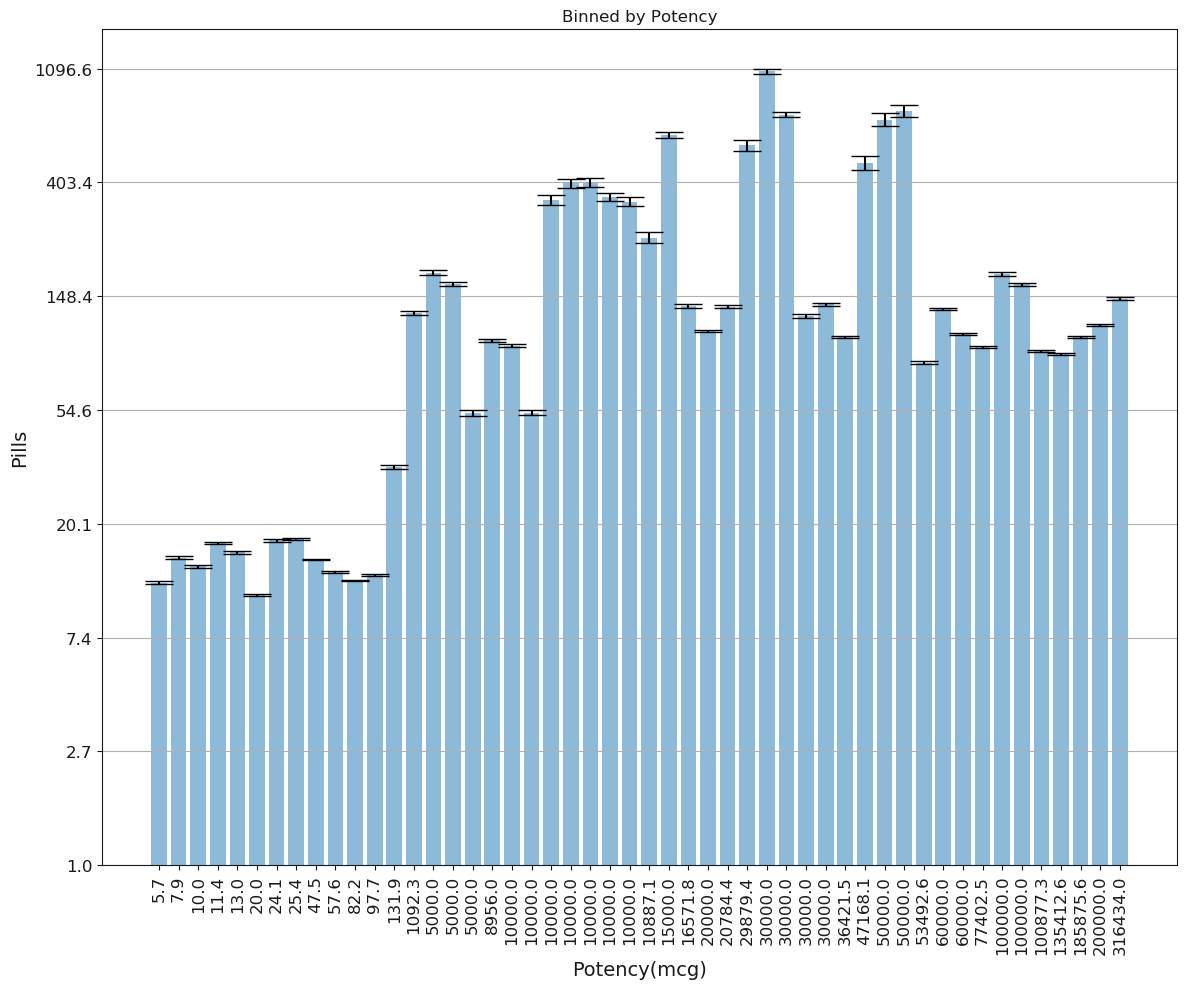

In [550]:
fig, ax = plt.subplots(figsize=(12,10))
x_pos = np.arange(1,51,1)

x_labels = ['{:0.1f}'.format(np.exp(binpotency_val[k])) for k in x_pos]

y_val = [binned_mean_potency_pills[k] for k in x_pos]
err = [binned_var_potency_pills[k] for k in x_pos]
ax.bar(x_pos, y_val, yerr=err, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Pills' , fontsize = 14)
ax.set_xlabel('Potency(mcg)',fontsize = 14)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation='90' , fontsize = 12)
ax.set_title('Binned by Potency')
ax.yaxis.grid(True)


ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


# Save the figure and show
plt.tight_layout()
plt.show()

[3.60162977e+10 3.84904474e+00 1.00000000e+00]
0.4564404014442066


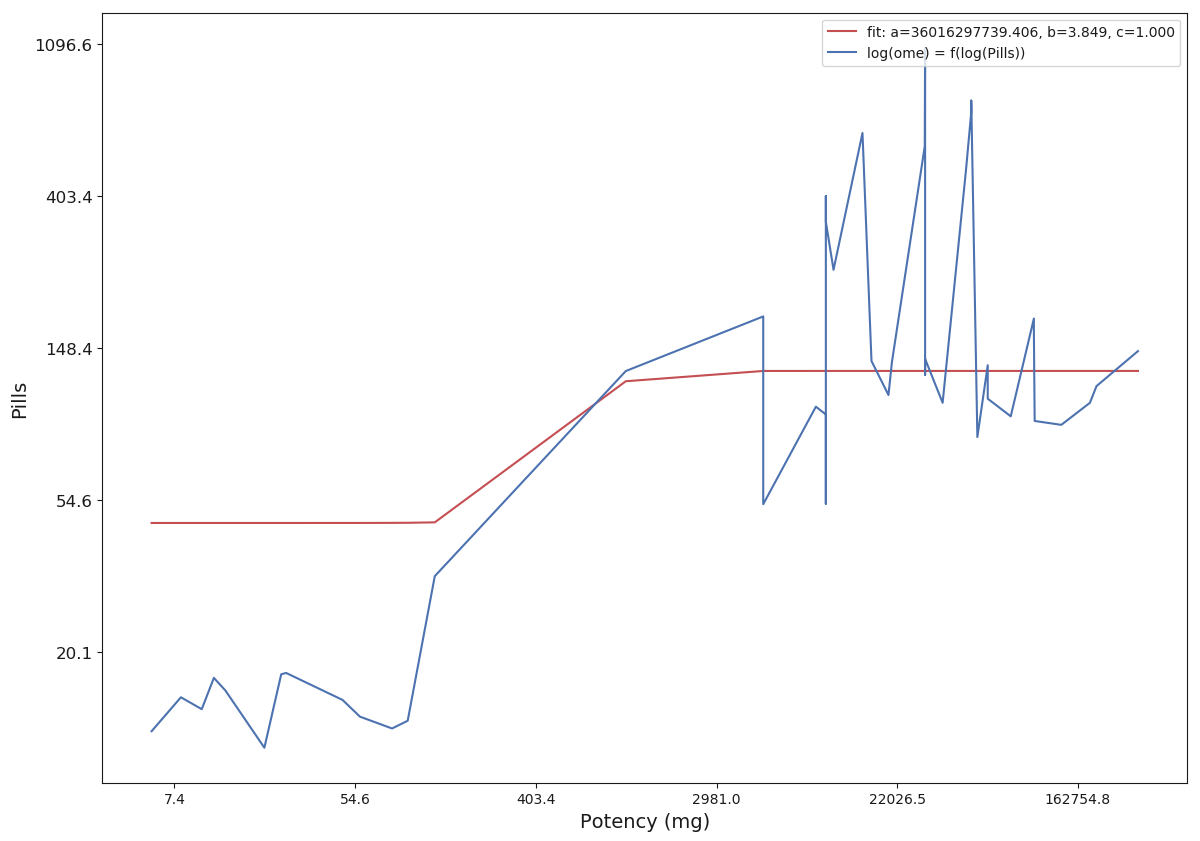

In [553]:
from scipy.optimize import curve_fit

def func(x, a, b , c):
    
    return (1.0/(1+a*np.exp(-b*x)) + b)
#     return a*np.exp(b*x)

y_val_new = [k for k in y_val]
x_val_new = [binpotency_val[k] for k in x_pos]

popt, pcov = curve_fit(func,x_val_new, y_val_new)
print(popt)

evaluate = [func(k , popt[0], popt[1], popt[2]) for k in x_val_new]

goodNessFit(np.array(y_val_new) , np.array(evaluate))

fig, ax = plt.subplots(figsize=(14,10))
plt.plot(x_val_new, evaluate, 'r-',  label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(x_val_new, y_val_new , 'b-',  label='log(ome) = f(log(Pills))')
plt.legend(loc='upper right')

ax.set_ylabel('Pills' , fontsize = 14)
ax.set_xlabel('Potency (mg)',fontsize = 14)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


plt.show()

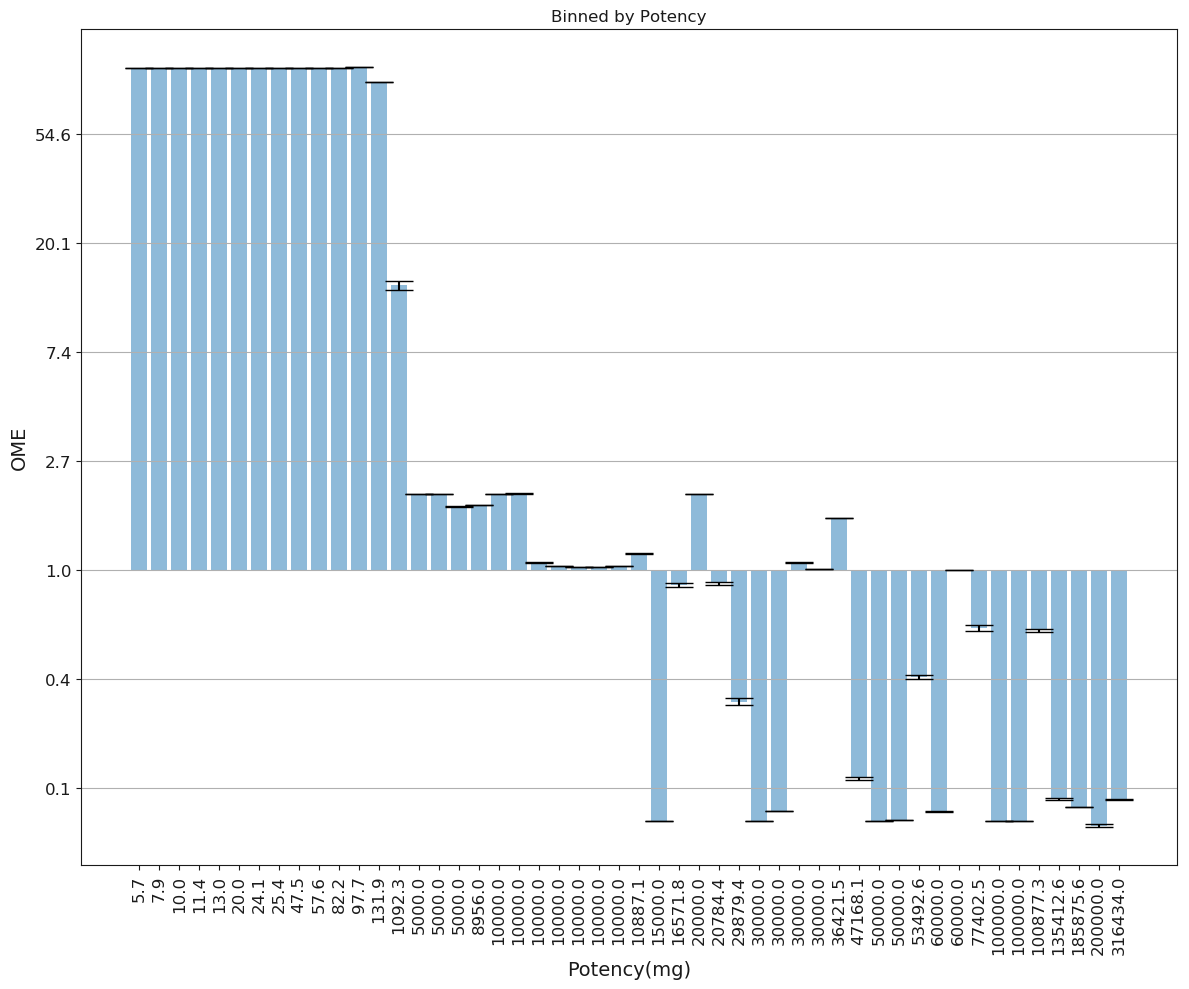

In [578]:
# Build the plot
fig, ax = plt.subplots(figsize=(12,10))
x_pos = np.arange(1,51,1)

x_labels = ['{:0.1f}'.format(np.exp(binpotency_val[k])) for k in x_pos]

y_val = [binned_mean_OME_potency[k] for k in x_pos]
err = [binned_var_OME_potency[k] for k in x_pos]
ax.bar(x_pos, y_val, yerr=err, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('OME' , fontsize = 14)
ax.set_xlabel('Potency(mg)',fontsize = 14)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation='90' , fontsize = 12)
ax.set_title('Binned by Potency')
ax.yaxis.grid(True)


ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


# Save the figure and show
plt.tight_layout()
plt.show()

/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


[61.42043748  0.5283483   1.        ]
0.8848096778284394


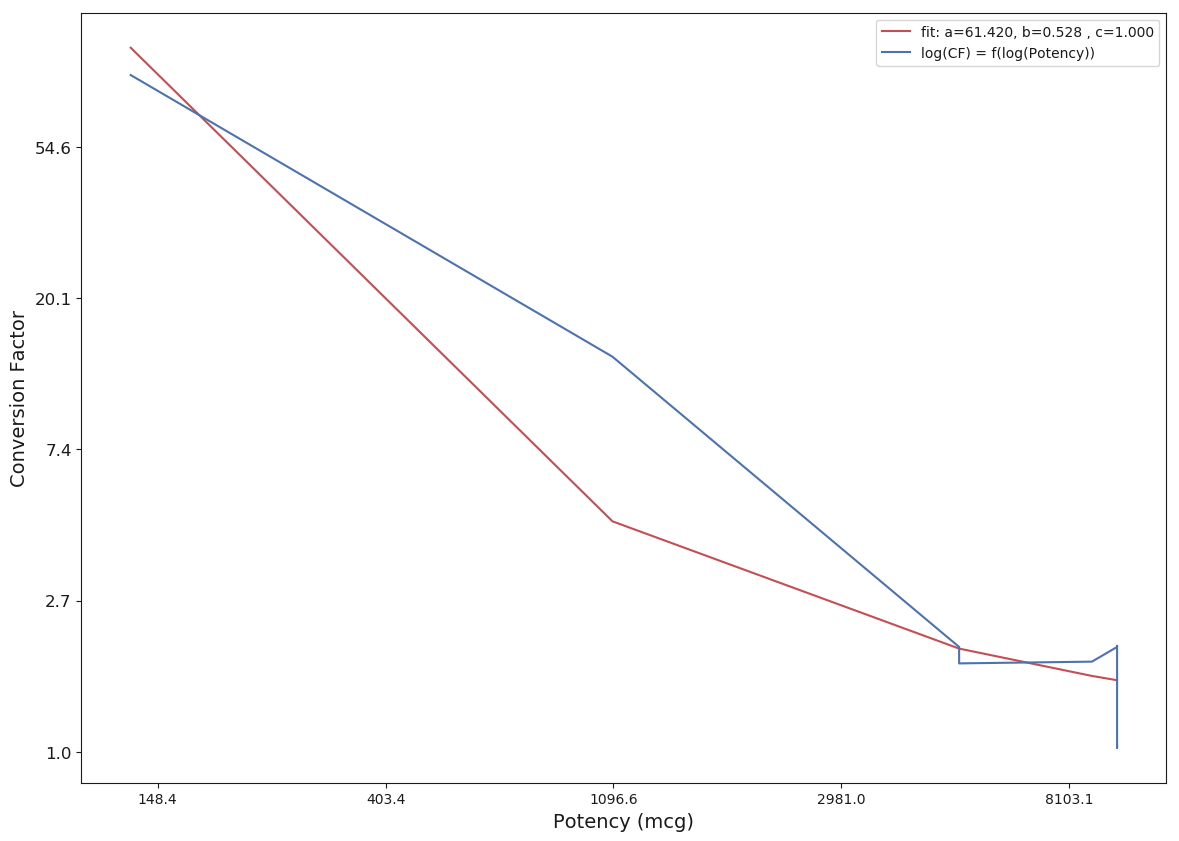

In [588]:
from scipy.optimize import curve_fit

def func(x, a, b , c):
    return a*np.exp(-b*x)

# y_val_new = [k for k in y_val]
# x_val_new = [binpotency_val[k] for k in x_pos]

y_val_new = [y_val[k] for k in range(len(x_pos)) if np.exp(binpotency_val[k+1]) <= 10000.0 and np.exp(binpotency_val[k+1]) > 100.0  ]
x_val_new = [binpotency_val[k] for k in x_pos if np.exp(binpotency_val[k]) <= 10000.0 and np.exp(binpotency_val[k]) > 100.0]

popt, pcov = curve_fit(func,x_val_new, y_val_new)
print(popt)

evaluate = [func(k , popt[0], popt[1], popt[2]) for k in x_val_new]

goodNessFit(np.array(y_val_new) , np.array(evaluate))

fig, ax = plt.subplots(figsize=(14,10))
plt.plot(x_val_new, evaluate, 'r-',  label='fit: a=%5.3f, b=%5.3f , c=%5.3f' % tuple(popt))
plt.plot(x_val_new, y_val_new , 'b-',  label='log(CF) = f(log(Potency))')
plt.legend(loc='upper right')

ax.set_ylabel('Conversion Factor' , fontsize = 14)
ax.set_xlabel('Potency (mcg)',fontsize = 14)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


plt.show()

[-5.75333659e+03  7.07210205e+02  1.00000000e+00]
-1.3005765291455496


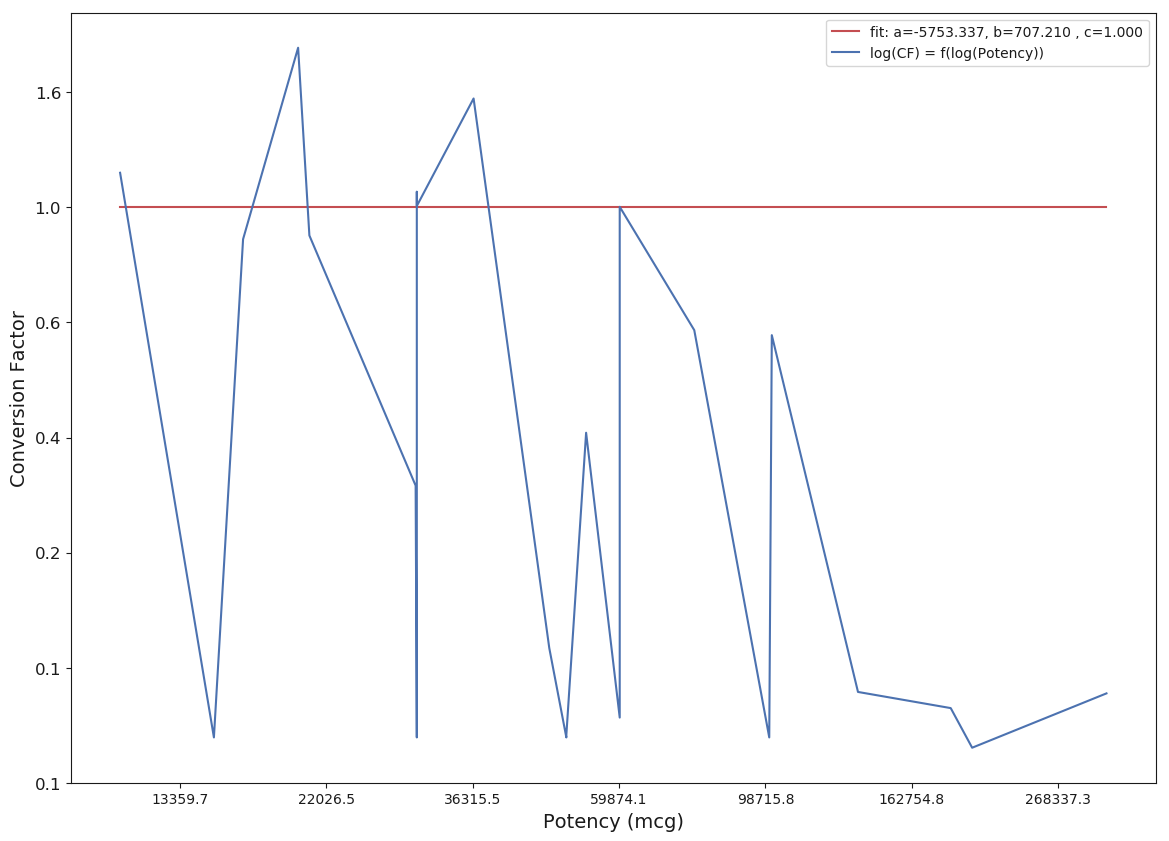

In [590]:
from scipy.optimize import curve_fit

def func(x, a, b , c):
    return a*np.exp(-b*x)

# y_val_new = [k for k in y_val]
# x_val_new = [binpotency_val[k] for k in x_pos]

y_val_new = [y_val[k] for k in range(len(x_pos)) if np.exp(binpotency_val[k+1]) > 10000.0]
x_val_new = [binpotency_val[k] for k in x_pos if np.exp(binpotency_val[k]) > 10000.0]

popt, pcov = curve_fit(func,x_val_new, y_val_new)
print(popt)

evaluate = [func(k , popt[0], popt[1], popt[2]) for k in x_val_new]

goodNessFit(np.array(y_val_new) , np.array(evaluate))

fig, ax = plt.subplots(figsize=(14,10))
plt.plot(x_val_new, evaluate, 'r-',  label='fit: a=%5.3f, b=%5.3f , c=%5.3f' % tuple(popt))
plt.plot(x_val_new, y_val_new , 'b-',  label='log(CF) = f(log(Potency))')
plt.legend(loc='upper right')

ax.set_ylabel('Conversion Factor' , fontsize = 14)
ax.set_xlabel('Potency (mcg)',fontsize = 14)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


plt.show()

In [564]:
# from scipy.optimize import curve_fit

# def func(x, a, b):
#     return a*np.exp(-b*x)

# y_val_new = [y_val[k] for k in range(len(x_pos)) if np.exp(binpotency_val[k+1]) >= 1.0]
# x_val_new = [binpotency_val[k] for k in x_pos if np.exp(binpotency_val[k]) >= 1.0]

# popt, pcov = curve_fit(func,x_val_new, y_val_new)
# print(popt)

# evaluate = [func(k , popt[0], popt[1]) for k in x_val_new]

# goodNessFit(np.array(y_val_new) , np.array(evaluate))

# fig, ax = plt.subplots(figsize=(14,10))
# plt.plot(x_val_new, evaluate, 'r-',  label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
# plt.plot(x_val_new, y_val_new , 'b-',  label='log(ome) = f(log(Potency))')
# plt.legend(loc='upper right')

# ax.set_ylabel('OME' , fontsize = 14)
# ax.set_xlabel('Potency (mg)',fontsize = 14)

# ax = plt.gca()
# ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
# ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
# plt.yticks(fontsize = 12)


# plt.show()

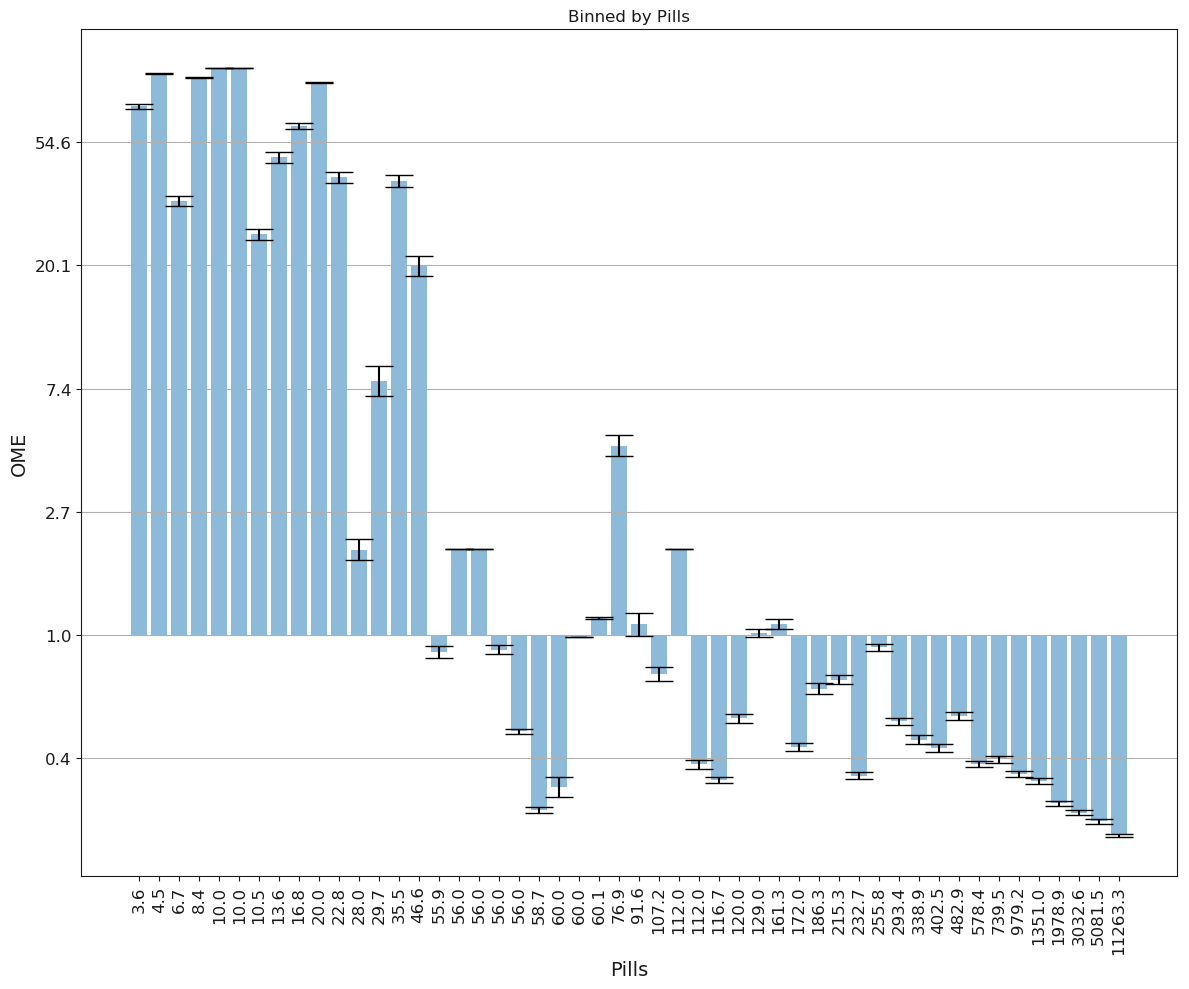

In [591]:
# Build the plot
fig, ax = plt.subplots(figsize=(12,10))
x_pos = np.arange(1,51,1)

x_labels = ['{:0.1f}'.format(np.exp(binpills_val[k])) for k in x_pos]

y_val = [binned_mean_OME_pills[k] for k in x_pos]
err = [binned_var_OME_pills[k] for k in x_pos]
ax.bar(x_pos, y_val, yerr=err, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_title('Binned by Pills')
ax.set_ylabel('OME' , fontsize = 14)
ax.set_xlabel('Pills',fontsize = 14)

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation='90' , fontsize = 12)


ax.yaxis.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


# Save the figure and show
plt.tight_layout()
plt.show()

[132.60155674   1.09101887  -1.17279295]
0.6011504412824702


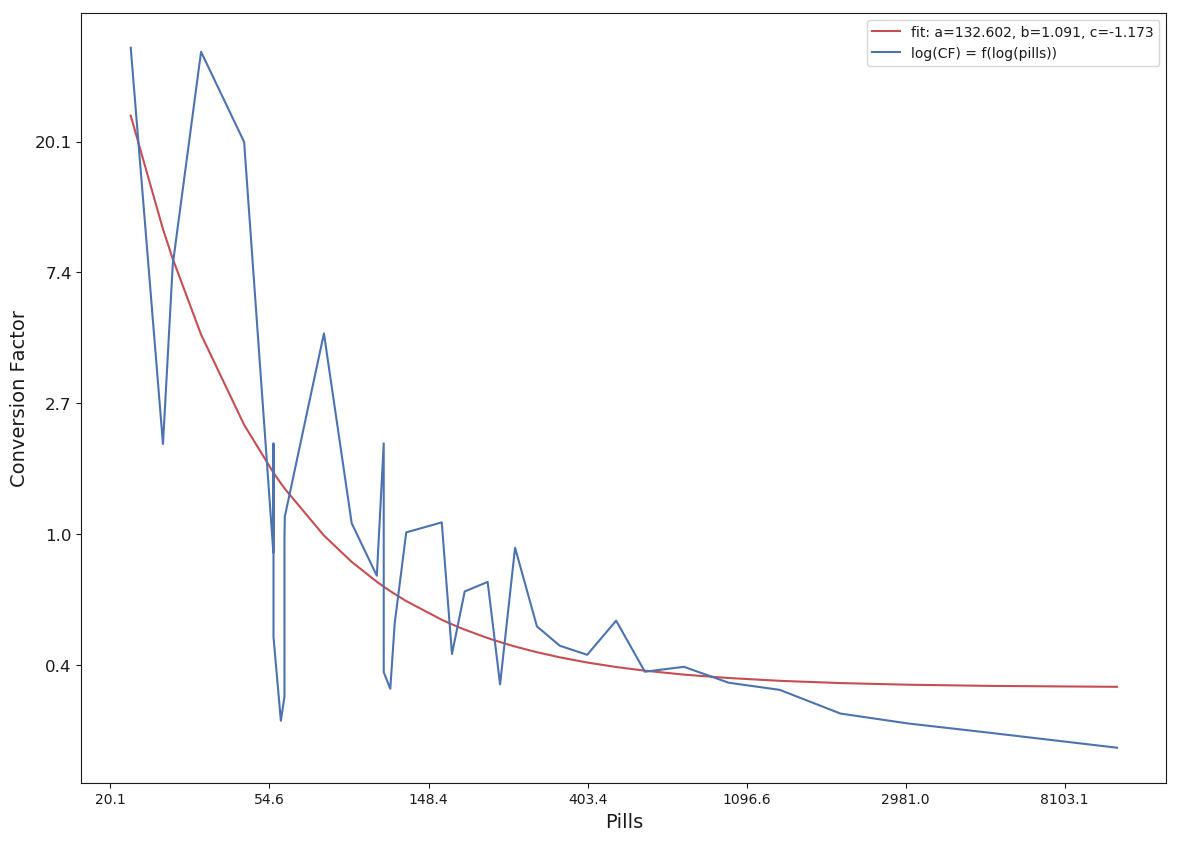

In [593]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*np.exp(-b*x) + c

y_val_new = [k for k in y_val]
x_val_new = [binpills_val[k] for k in x_pos]

y_val_new = [y_val[k] for k in range(len(x_pos)) if np.exp(binpills_val[k+1]) > 20.0]
x_val_new = [binpills_val[k] for k in x_pos if np.exp(binpills_val[k]) > 20.0]

popt, pcov = curve_fit(func,x_val_new, y_val_new)
print(popt)

evaluate = [func(k , popt[0], popt[1], popt[2]) for k in x_val_new]

goodNessFit(np.array(y_val_new) , np.array(evaluate))

fig, ax = plt.subplots(figsize=(14,10))
plt.plot(x_val_new, evaluate, 'r-',  label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(x_val_new, y_val_new , 'b-',  label='log(CF) = f(log(pills))')
plt.legend(loc='upper right')
ax.set_ylabel('Conversion Factor' , fontsize = 14)
ax.set_xlabel('Pills',fontsize = 14)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


plt.show()

[13.24864242  0.32206273 -2.7987765 ]
0.7760233099372921


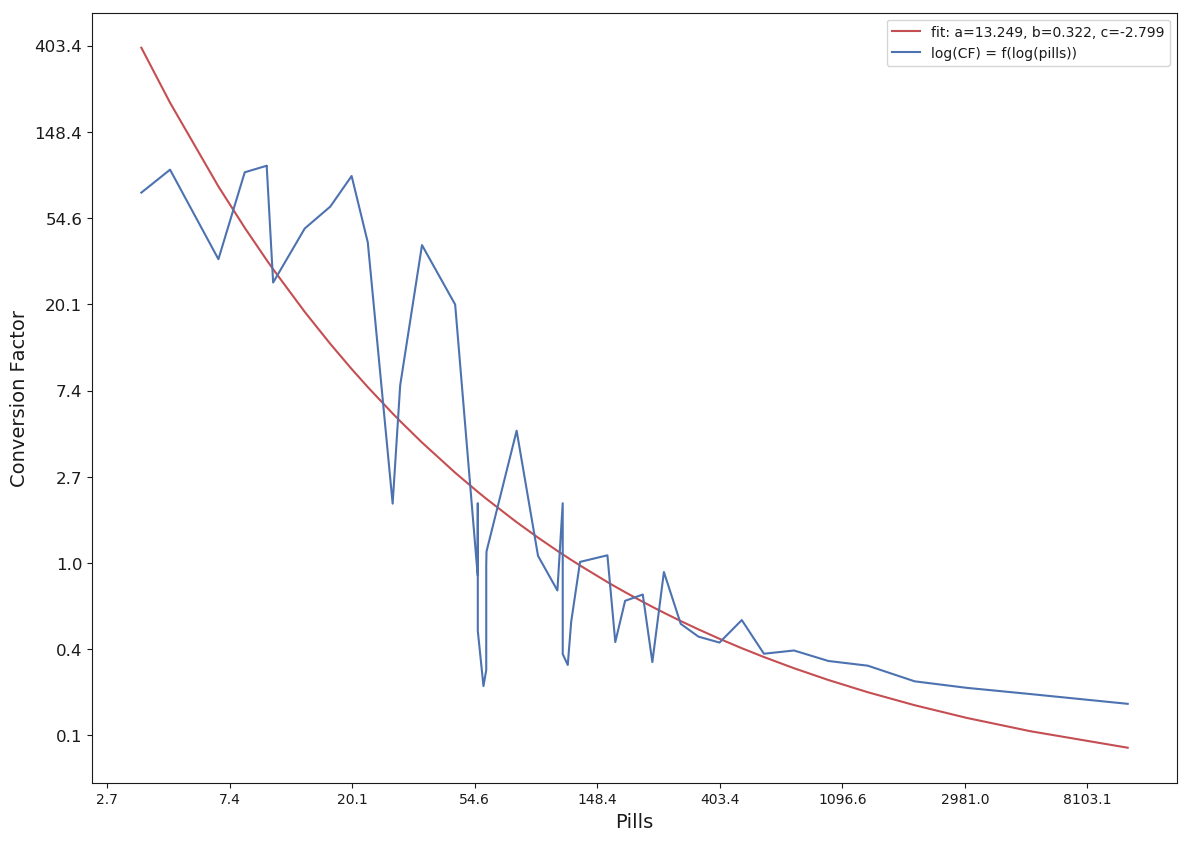

In [594]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*np.exp(-b*x) + c

y_val_new = [k for k in y_val]
x_val_new = [binpills_val[k] for k in x_pos]

# y_val_new = [y_val[k] for k in range(len(x_pos)) if np.exp(binpills_val[k+1]) > 20.0]
# x_val_new = [binpills_val[k] for k in x_pos if np.exp(binpills_val[k]) > 20.0]

popt, pcov = curve_fit(func,x_val_new, y_val_new)
print(popt)

evaluate = [func(k , popt[0], popt[1], popt[2]) for k in x_val_new]

goodNessFit(np.array(y_val_new) , np.array(evaluate))

fig, ax = plt.subplots(figsize=(14,10))
plt.plot(x_val_new, evaluate, 'r-',  label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(x_val_new, y_val_new , 'b-',  label='log(CF) = f(log(pills))')
plt.legend(loc='upper right')
ax.set_ylabel('Conversion Factor' , fontsize = 14)
ax.set_xlabel('Pills',fontsize = 14)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


plt.show()

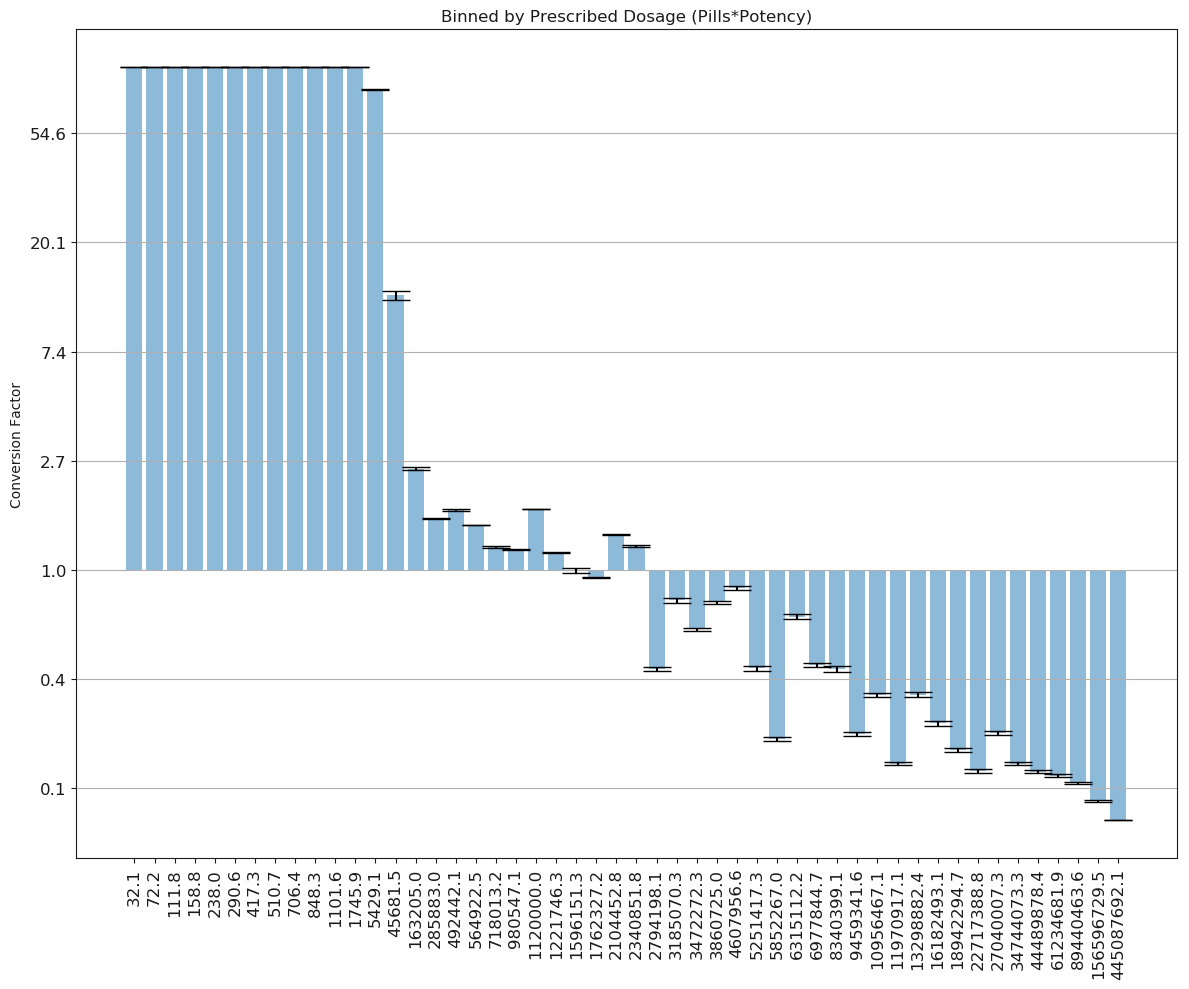

In [599]:
# Build the plot
fig, ax = plt.subplots(figsize=(12,10))
x_pos = np.arange(1,51,1)


x_labels = ['{:0.1f}'.format(np.exp(bindosage_val[k])) for k in x_pos]


y_val = [binned_mean_OME_dosage[k] for k in x_pos]
err = [binned_var_OME_dosage[k] for k in x_pos]
ax.bar(x_pos, y_val, yerr=err, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Conversion Factor')

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation='90' , fontsize = 12)

ax.set_title('Binned by Prescribed Dosage (Pills*Potency)')
ax.yaxis.grid(True)


ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)

# Save the figure and show
plt.tight_layout()
plt.show()

/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


[24.75353154  0.10627242 -5.55461964]
0.9426859340941036


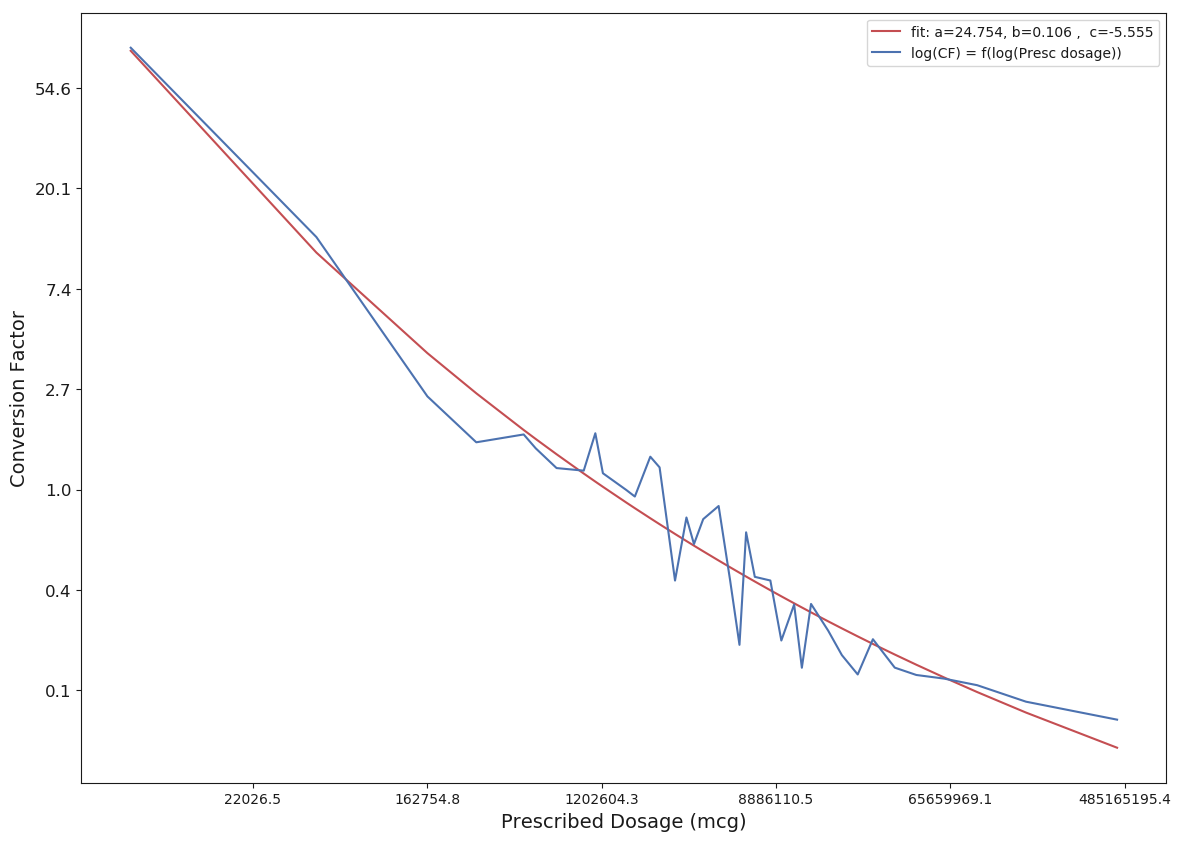

In [600]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*np.exp(-b*x)

def func(x, a, b, c):
    return a*np.exp(-b*x) + c

# y_val_new = [k for k in y_val]
# x_val_new = [bindosage_val[k] for k in x_pos]

y_val_new = [y_val[k] for k in range(len(x_pos)) if np.exp(bindosage_val[k+1]) >= 2000.0]
x_val_new = [bindosage_val[k] for k in x_pos if np.exp(bindosage_val[k]) >= 2000.0]

popt, pcov = curve_fit(func,x_val_new, y_val_new)
print(popt)

evaluate = [func(k , popt[0], popt[1], popt[2]) for k in x_val_new]

goodNessFit(np.array(y_val_new) , np.array(evaluate))

fig, ax = plt.subplots(figsize=(14,10))
plt.plot(x_val_new, evaluate, 'r-',  label='fit: a=%5.3f, b=%5.3f ,  c=%5.3f' % tuple(popt))
plt.plot(x_val_new, y_val_new , 'b-',  label='log(CF) = f(log(Presc dosage))')
plt.legend(loc='upper right')
ax.set_ylabel('Conversion Factor' , fontsize = 14)
ax.set_xlabel('Prescribed Dosage (mcg)',fontsize = 14)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


plt.show()

In [603]:
np.exp(np.mean([y_val[k] for k in range(len(x_pos)) if np.exp(bindosage_val[k+1]) < 2000.0]))

100.05325325094327

[2.1257751  9.87936883 4.60570258]
-5.651035195342047e-13


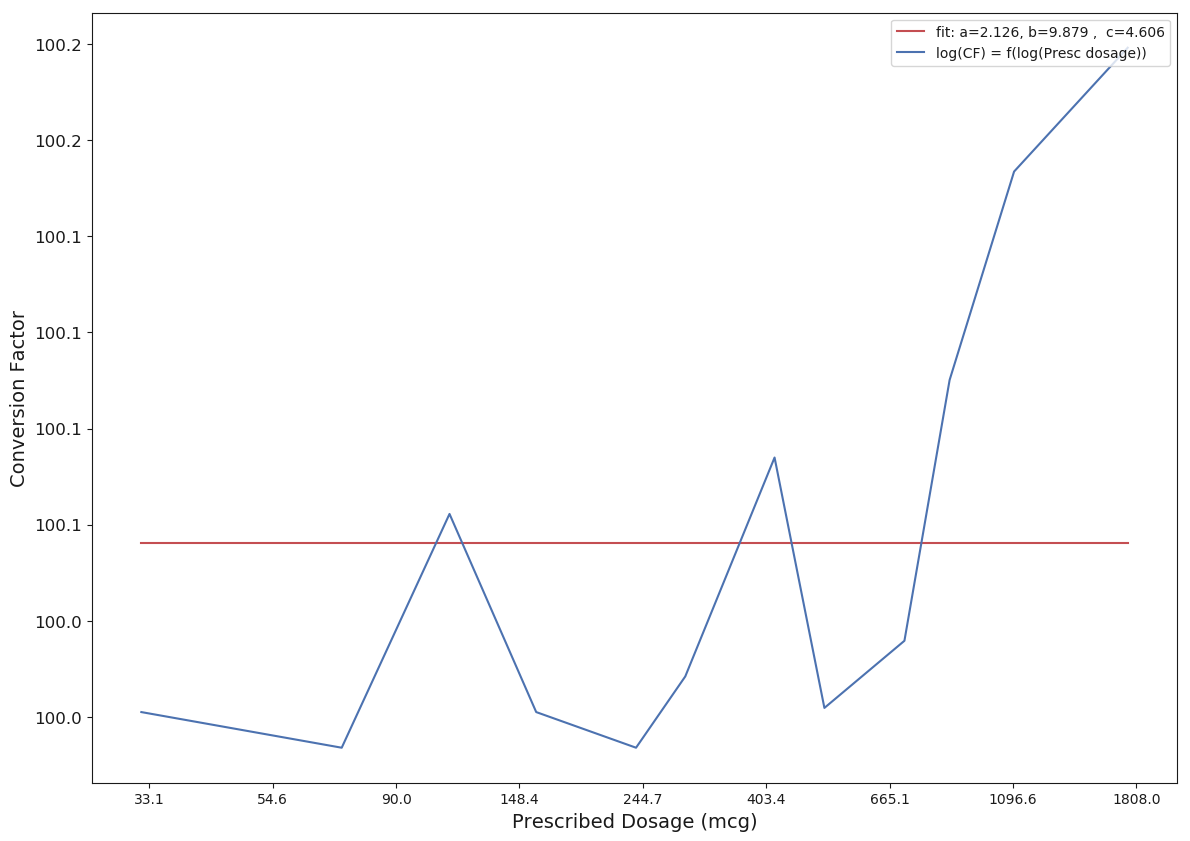

In [597]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*np.exp(-b*x)

def func(x, a, b, c):
    return a*np.exp(-b*x) + c

# y_val_new = [k for k in y_val]
# x_val_new = [bindosage_val[k] for k in x_pos]

y_val_new = [y_val[k] for k in range(len(x_pos)) if np.exp(bindosage_val[k+1]) < 2000.0]
x_val_new = [bindosage_val[k] for k in x_pos if np.exp(bindosage_val[k]) < 2000.0]

popt, pcov = curve_fit(func,x_val_new, y_val_new)
print(popt)

evaluate = [func(k , popt[0], popt[1], popt[2]) for k in x_val_new]

goodNessFit(np.array(y_val_new) , np.array(evaluate))

fig, ax = plt.subplots(figsize=(14,10))
plt.plot(x_val_new, evaluate, 'r-',  label='fit: a=%5.3f, b=%5.3f ,  c=%5.3f' % tuple(popt))
plt.plot(x_val_new, y_val_new , 'b-',  label='log(CF) = f(log(Presc dosage))')
plt.legend(loc='upper right')
ax.set_ylabel('Conversion Factor' , fontsize = 14)
ax.set_xlabel('Prescribed Dosage (mcg)',fontsize = 14)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


plt.show()

0.8640729947237071


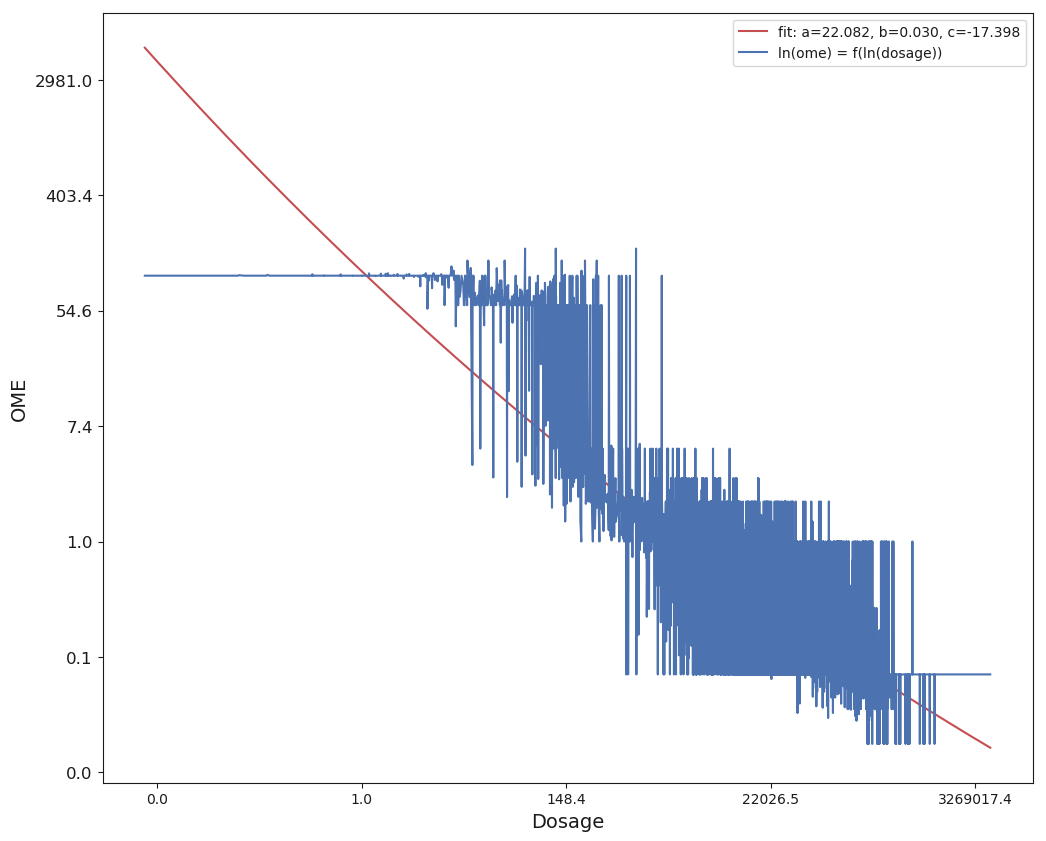

In [448]:
ome_df.sort_values(by='ln_dosage',inplace=True)

dosage_ome_dict = {'mean_ome':[] , 'ln_dosage':[]}
for name , group in ome_df.groupby('ln_dosage'):
    dosage_ome_dict['ln_dosage'].append(name)
    dosage_ome_dict['mean_ome'].append(np.mean(group['ln_ome']))
dosage_ome_df = pd.DataFrame.from_dict(dosage_ome_dict)

from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*np.exp(-b*x) + c

popt, pcov = curve_fit(func,dosage_ome_df['ln_dosage'], dosage_ome_df['mean_ome'])



goodNessFit(dosage_ome_df['mean_ome'], func(dosage_ome_df['ln_dosage'], *popt))

fig, ax = plt.subplots(figsize=(12,10))
plt.plot(dosage_ome_df['ln_dosage'], func(dosage_ome_df['ln_dosage'], *popt), 'r-',  label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(dosage_ome_df['ln_dosage'], dosage_ome_df['mean_ome'] , 'b-',  label='ln(ome) = f(ln(dosage))')
# ax.set_xticklabels([np.exp(k) for k in dosage_ome_df['ln_dosage'].tolist()])
plt.legend(loc='upper right')
ax.set_ylabel('OME' , fontsize = 14)
ax.set_xlabel('Dosage',fontsize = 14)
ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)
plt.show()

In [281]:
# residual sum of squares
ss_res = np.sum((dosage_ome_df['mean_ome'] - func(dosage_ome_df['ln_dosage'],*popt)) ** 2)

# total sum of squares
ss_tot = np.sum((dosage_ome_df['mean_ome'] - np.mean(dosage_ome_df['mean_ome'])) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

0.8640729947236745


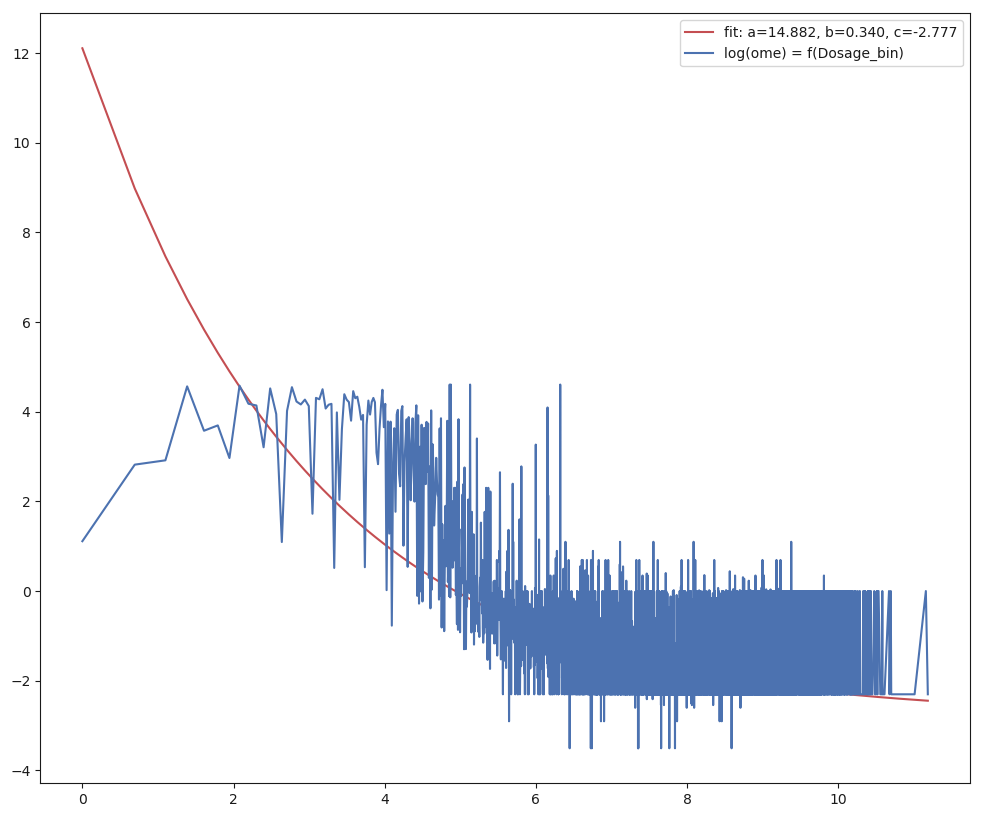

In [282]:
ome_df.sort_values(by='ln_pills',inplace=True)

dosage_ome_dict = {'mean_ome':[] , 'ln_pills':[]}
for name , group in ome_df.groupby('ln_pills'):
    dosage_ome_dict['ln_pills'].append(name)
    dosage_ome_dict['mean_ome'].append(np.mean(group['ln_ome']))
dosage_ome_df = pd.DataFrame.from_dict(dosage_ome_dict)

from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*np.exp(-b*x) + c

popt, pcov = curve_fit(func,dosage_ome_df['ln_pills'], dosage_ome_df['mean_ome'])

fig, ax = plt.subplots(figsize=(12,10))
plt.plot(dosage_ome_df['ln_pills'], func(dosage_ome_df['ln_pills'], *popt), 'r-',  label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(dosage_ome_df['ln_pills'], dosage_ome_df['mean_ome'] , 'b-',  label='log(ome) = f(Dosage_bin)')
plt.legend(loc='upper right')
plt.show()

In [283]:
# residual sum of squares
ss_res = np.sum((dosage_ome_df['mean_ome'] - func(dosage_ome_df['ln_pills'],*popt)) ** 2)

# total sum of squares
ss_tot = np.sum((dosage_ome_df['mean_ome'] - np.mean(dosage_ome_df['mean_ome'])) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

0.38002286240117433


In [ ]:
def logit(x):
    return 1.0/(1.0 + 3*np.exp(-4*x))

In [ ]:
plt.plot(dosage_ome_df['ln_potency'] , logit(ln_potency)

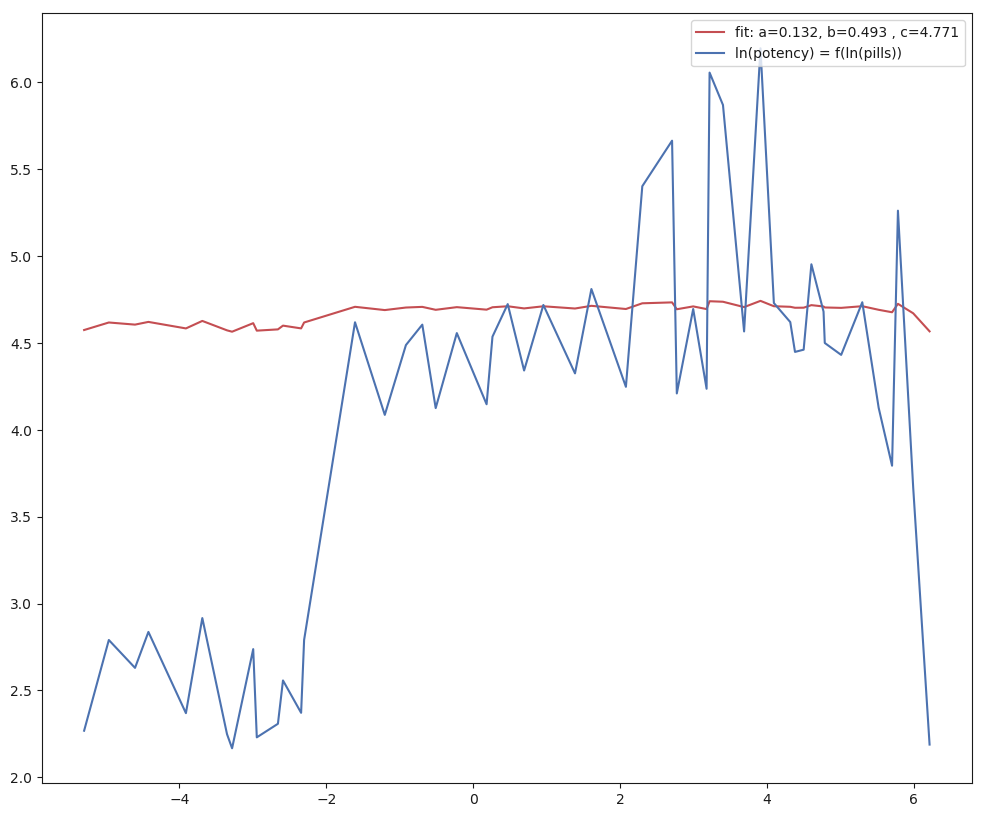

In [322]:
ome_df.sort_values(by='ln_potency',inplace=True)

dosage_ome_dict = {'mean_pills':[] , 'ln_potency':[]}
for name , group in ome_df.groupby('ln_potency'):
    dosage_ome_dict['ln_potency'].append(name)
    dosage_ome_dict['mean_pills'].append(np.mean(group['ln_pills']))
dosage_ome_df = pd.DataFrame.from_dict(dosage_ome_dict)

from scipy.optimize import curve_fit

def func(x, a, b ,c ):
    return c / (1.0 + a*np.exp(-b*x))

popt, pcov = curve_fit(func,dosage_ome_df['ln_potency'], dosage_ome_df['mean_pills'], bounds=(0 , [1., 3 , 100]))

fig, ax = plt.subplots(figsize=(12,10))
plt.plot(dosage_ome_df['ln_potency'], func(dosage_ome_df['mean_pills'], *popt), 'r-',  label='fit: a=%5.3f, b=%5.3f , c=%5.3f' % tuple(popt))
plt.plot(dosage_ome_df['ln_potency'], dosage_ome_df['mean_pills'] , 'b-',  label='ln(potency) = f(ln(pills))')
plt.legend(loc='upper right')
plt.show()

In [271]:
pcov

array([[1.66362995e-01, 2.87817011e-03, 1.04318547e-02],
       [2.87817011e-03, 6.89869565e-05, 3.21656529e-04],
       [1.04318547e-02, 3.21656529e-04, 1.77416017e-03]])

In [204]:
len(set(ome_df['3']))

436

In [232]:
pearsonr(ome_df['27'],ome_df['15'])

(-0.38456891755604494, 0.0)

In [233]:
ome_df_new = ome_df[ome_df['15']>0]

In [234]:
ome_df_new['27'] = 1/ome_df_new['24']

In [235]:
ome_df_new['28'] = ome_df_new['26']/ome_df_new['8']

Text(0.5,0,'ln(ome)')

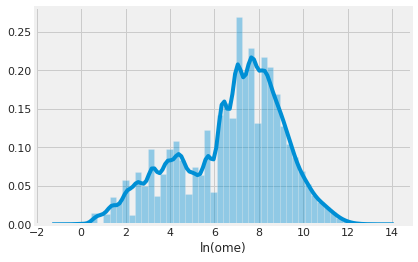

In [236]:
sns.distplot(np.log(ome_df_new['26']))
plt.xlabel('ln(ome)')

In [ ]:
sns.distplot(np.log(ome_df_new['27']))
plt.xlabel('ln(Quantity/Potency)')

In [ ]:
pearsonr(np.log(ome_df_new['28']) ,np.log(ome_df_new['15']))

In [ ]:
sub_df = ome_df_new[['24','26','27','15','4']]
sub_df.head()

In [ ]:
sub_df['26'] = np.log(sub_df['26'])
sub_df['27'] = np.log(sub_df['27'])
sub_df['24'] = np.log(sub_df['24'])

In [ ]:
Y_dims = ['26']
X_dims = ['24']

min_max_scaler = preprocessing.MinMaxScaler() 
Y_ome = min_max_scaler.fit_transform(np.array(sub_df[Y_dims].values,dtype=np.float32))
X_model = min_max_scaler.fit_transform(np.array(sub_df[X_dims].values,dtype=np.float32))

X_model = sm.add_constant(X_model)
print(X_model)
model = sm.OLS(Y_ome, X_model).fit()
model.summary()

In [ ]:
predicted = model.predict(X_model)

sns.regplot(sub_df['26'],predicted)
plt.xlabel('ln(ome)')
plt.ylabel('normalized predicted ln(ome)')

In [ ]:
sns.distplot(np.log(ome_df_new['8']))

In [ ]:
sns.distplot(np.log(ome_df_new['15']))

In [ ]:
drug_identifiers = opioids_ome['24'].unique()

In [ ]:
features = {'ome':[], 'mean_pills':[], 'sigma_pills':[],'mean_potency':[], 'sigma_potency' : [] , 'BNF':[] , 'mean_cost':[] ,'sigma_cost':[] , 'mean_dosage':[] , 'sigma_dosage':[] }
for name , group in opioids_ome.groupby('24'):
#     if bnf_ome_map[name] < 10:
    features['BNF'].append(name)
    features['mean_pills'].append(np.mean(group['8']))
    features['sigma_pills'].append(np.std(group['8']))
    features['mean_potency'].append(np.mean(group['15']))
#     features['min_potency'].append(np.min(group['15']))
#     features['max_potency'].append(np.max(group['15']))
    features['sigma_potency'].append(np.std(group['15']))
    features['mean_cost'].append(np.mean(group['7']))
    features['sigma_cost'].append(np.std(group['7']))
    features['mean_dosage'].append(np.mean(group['19']))
    features['sigma_dosage'].append(np.std(group['19']))
    features['ome'].append(bnf_ome_map[name])
features = pd.DataFrame.from_dict(features)

In [ ]:
features = features[features['mean_potency']!=0]

In [ ]:
features.head()

In [ ]:
features[features['mean_potency'] == 0.0]

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))         
corr = features.corr(method='pearson')
sns.heatmap(corr, annot=True , ax=ax ,cmap='Reds' )
ax.set_xticklabels(corr.columns, fontsize=15)
ax.set_yticklabels(corr.columns, fontsize=15)

In [ ]:
sns.regplot(features['ome'],features['mean_potency'])

In [ ]:
sns.distplot(np.log(features['mean_dosage']))
plt.xlabel("ln(mean_dosage)")

In [ ]:
sns.distplot(np.log(features['mean_cost']))
plt.xlabel("ln(mean_cost)")

In [ ]:
sns.distplot(np.log(features['mean_potency']))
plt.xlabel("ln(mean_potecy)")

In [ ]:
sns.distplot(np.log(features['ome']))
plt.xlabel("ln(ome)")

In [ ]:
features['ln_mean_potency'] = np.log(features['mean_potency'])
features['ln_mean_dosage'] = np.log(features['mean_dosage'])
features['ln_mean_cost'] = np.log(features['mean_potency'])
features['ln_mean_pills'] = np.log(features['mean_pills'])
features['ln_Impact'] = np.log(features['mean_potency']/features['mean_pills'])

In [ ]:
sns.distplot(features['ln_Impact'])

In [ ]:
# features_to_normalize = ['ln_mean_potency','ln_mean_dosage','ln_mean_cost']
# features[features_to_normalize] = features[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [ ]:
Y_dims = ['ome']
X_dims = ['ln_Impact']

min_max_scaler = preprocessing.MinMaxScaler() 
Y_ome = min_max_scaler.fit_transform(np.array(features[Y_dims].values,dtype=np.float32))
X_model = np.array(features[X_dims].values,dtype=np.float32)

X_model = sm.add_constant(X_model)
print(X_model)
model = sm.OLS(Y_ome, X_model).fit()
model.summary()

In [ ]:
predicted = model.predict(X_model)

sns.regplot(np.log(features['ome']),predicted)
plt.xlabel('ln(ome)')
plt.ylabel('normalized predicted ln(ome)')